# Mural de Quests 3: Modelos 8

* Aniel de Souza Ribeiro Neto
* Joaquim Junior Ferola Fonseca
* Matheus Pereira Velloso da Silveira

## Introdução

Quando trabalhamos com conjunto de dados para construir modelos de aprendizado de máquina, capazes de prever novos dados com base nas relações entre características, chamadas atributos, dos dados iniciais, parece intuitivo imaginar que quanto maior o número de dados e atributos mais precisos serão os modelos treinados, uma vez que teriam mais informações para suas previsões. Entretanto, quando estamos trabalhando em situações reais de aprendizado de máquina, normalmente não trabalharemos com conjuntos de dados ideais e, nestes casos, nem sempre um maior montante de dados e atributos é benéfico. Em casos reais é possível que nem todos atributos contribuam de fato para a previsão, assim seu uso no treino só estaria aumentando o custo computacional e poderiam ainda afetar negativamento o desempenho do modelo, ou alguns atributos poderiam estar correlacionados, ou seja, possuem uma relação de que o valor de um dado inflencia o valor do outro, podendo trazer informações redundantes ao modelo, já que um dado já implicava no outro, e novamente atrapalhar o desempenho do modelo. 

Dessa forma, neste trabalho estudaremos formas de lidar com conjunto de dados com muitos atributos e dados, de forma que não saibamos quais atributos contribuem de fato para a previsão dos dados. Para isso, compararemos o desempenho de modelos treinados com três estratégias diferentes para lidar com esses dados, *Principal component analysis*, *Variance Threshold* e *Recursive feature elimination*, a modelos treinados sem essas estratégias, utilizando otimização de hiperparâmetros através do módulo optuna para encontrar o conjunto de parâmtros de maior desempenho em cada modelo. 

## Módulos Utilizados

In [1]:
from sklearn.datasets import make_regression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from optuna import create_study
import matplotlib.pyplot as plt

## Construindo um Dataset Sintético

Neste trabalho utilizaremos um conjunto de dados sintéticos para regressão criado através da função `make_regression` do `sklearn`. Como o objetivo deste trabalho é o estudo das estratégias de tratamento de dados e atributos e não o que será previsto de fato pelos modelos, utilizar um dataset sintético não irá afetar negativamente o estudo, mas sim nos permitirá controlar melhor as condições do problema. Assim, criaremos um conjunto de dados com 50 atributos, dos quais 40 possuem informações realmente úteis à previsão, e com 3900 observações, aplicaremos também um ruído aos dados, para tornar o problema mais próximo das condições de um problema real.

In [7]:
# Definindo a semente a aleatória
seed = 393939

# Criando um dataset sintético para regressão
atributos, targets = make_regression(
    n_samples=3900, # Número de dados/observações
    n_features=50, # Quantidade de atributos
    n_informative=40, # Número de atributos que possuem informações uteis à previsão
    n_targets=1, # Quantidade de targets
    noise=1, # Ruído adicionado aos dados
    random_state=seed # Semente do gerador aleatório
)

# Apresentando os dados em dataframe pandas
df_atributos = pd.DataFrame(atributos)
df_targets = pd.DataFrame(targets, columns=["target"])

print("Atributos \n", df_atributos)
print()
print("Targets \n", df_targets)

Atributos 
             0         1         2         3         4         5         6   \
0     1.285758 -0.701044 -1.137632 -0.566916 -2.641340 -0.715047 -0.583711   
1    -1.631318 -2.500269  0.449882 -0.440676 -0.110955 -1.009863 -1.524667   
2     1.821020 -0.393637 -1.070786 -0.904687 -0.210363  0.128732  0.619689   
3    -0.585751 -0.556913  0.642989  1.288167 -0.480324  1.142039  0.673825   
4    -0.253934 -2.221010 -0.039462  1.149936 -0.504482  0.073853  0.257984   
...        ...       ...       ...       ...       ...       ...       ...   
3895  0.504595 -1.551060 -0.715665 -0.511046 -1.355965 -1.035999  1.612786   
3896 -1.444483 -0.286244 -0.113405  0.769947 -1.323779 -1.577215  0.334034   
3897  0.630701  0.081398 -1.679998  2.129849  0.252410 -0.621963  1.975690   
3898 -0.576631  0.580944  0.433366  0.200449 -0.089619 -1.512675 -1.306770   
3899 -0.135298  0.952244 -0.463421  0.738058 -0.559304  0.261757 -0.992136   

            7         8         9   ...        40  

## Separando os Dados para Treino, Teste e Validação

Como estamos trabalhando com muitos dados e modelos o uso de validação cruzada para validação dos modelos seria muito custoso computacionalmente. Portanto, utilizaremos neste trablho uma divisão dos dados em treino, tesste e validação, na qual vamos dividir 10% dos dados iniciais para teste final do modelo, e 10% dos dados restantes para treino para validação dos modelos, o restante dos dados serão usados para treino dos modelos. 

In [8]:
# Separando os dados de treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(
    df_atributos, # Atributos
    df_targets, # Targets
    test_size=0.10, # Quantidade de dados a serem pegos para teste
    random_state=seed # Semente aleatória
)

# Separando os dados de treino e validação 
x_treino_, x_val, y_treino_, y_val = train_test_split(
    x_treino, # Atributos de treino
    y_treino, # Targets de treino
    test_size=0.10, # Quantidade de dados a serem pegos para validação
    random_state=seed # Semente aleatória
)

## Algoritmos de Redução de Dimensionalidade

O algoritmo *Principal Component Analysis*, ou PCA, que aplicaremos neste trabalho é utilizado para auxiliar na redução de dimensionalidade dos dados, permitindo reduzir o impacto de problemas como redundância de dados. Vamos começar com uma visão geral do PCA. Como o nome indica, o PCA é uma tranformação linear que leva os dados de um espaço definido nas bases dos atributos para um espaço definindo por $n$ componetes, ortogonais entre sí e formadas por uma combinação linear dos atributos, de forma que a primeira componente, $PC1$ englobe a maior variância dos dados, seguida pela componente $PC2$ e assim sucessivamente até $PCn$, que deve possuir a menor quantidade de variância dos dados. Assim, por ser uma tranformação linear os dados mantêm sua esparsidade ao passo que perdem sua correlação, uma vez que foram decompostos em componentes ortogonais entre sí. Por fim, agora que temos os dados em um espaço com dimensões ordenadas por quantidade de variância, podemos remover a última dimensão, $PCn$, com a segurança de que estaremos perdendo a maior quantidade de informação possível em relação às outras dimensões. 

Para implementar o PCA neste trabalho utilizaremos a classe `PCA` do `sklearn.decomposition`, que recebe o número de componentes a serem mantidas. 

## Algoritmos de Seleção de Atributos

Enquanto no PCA foram removidas dimensões de menor variância formadas por combinações lineares dos atributos, nos algoritmos de seleção de atributos iremos remover de fato atributos não relevantes ao modelo. Neste trabalho iremos apicar duas estratégias de seleção de atributos, a *Variance Threshold* e a *Recursive feature elimination*.

### $\bullet$ Variance Threshold 

Atributos sem variância dos dados não trazem consigo nenhuma informação à predição, não há padrão a ser inferido em dados iguais, portanto, é uma boa prática remover atributos com nenhuma prática. Para isso existe a estratégia *variance threshold*, que remove atributos com variância inferior a um valor escolhido, portanto o nome. Vale notar que, embora o valor do limiar possa ser arbitráriamente escolhido, remover atributos por apresentarem pouca variância deve ser feito com cautela e noção do que está sendo feito, para que não haja perda de informação relevante. 

Para implementar o VarianceThreshold utilizaremos a classe `VarianceThreshold` do `sklearn.feature_selection`, que recebe o valor de variância a ser utilizado como limiar.

### $\bullet$ Recursive feature elimination 

Alguns modelos como modelos lineares, árvores de decisão e florestas aleatórias são capazes de atribuir um peso, ou importância, a cada atributo para a previsão do modelo, assim, remover os atributos de menor valor pode ser ajudar a remover atributos sem importância ao modelo. Para isso, o algoritmo *Recursive feature elimination*, ou RFE, funciona treinando um modelo capaz de atribuir importância aos atributos, de preferência um modelo igual ao que será utilizado para previsão dos dados, e removendo o atributo de menor importância, repetindo esse processo até que restem $n$ atributos definindos pelo usuário. 

Para implementar o RFE utlilizaremos a classe `RFE` também do `sklearn.feature_selection`, que recebe o modelo a ser utilizado como critério e o número de atributos a serem mantidos. 

## Tunando Modelos com Optuna

Neste trabalho utilizaremos o módulo `optuna` para encontrar uma boa combinação de hiperparâmetros e técnicas de tratamento de dados para o modelo e conjunto de dados dentro de um número definido de tentivas. Vamos dividir o processo de tunagem dos modelos em 6 etapas: 

1. Criar a função para instânciar os modelos: A função que possui os critérios que o optuna testará, retornando o modelo com os parâmetros definidos pelo optuna.
2. Criar a função que será otimizada pelo optuna: A função que computará a métrica a ser minimizada ou maximizada pelo optuna.
3. Criar um estudo do optuna: Arquivo onde serão salvos os testes e resultados do optuna.
4. Indicar testes desejados: Indicar testes com valores específicos que desejamos que o optuna teste.
5. Criar a função objetivo parcial: Função que retorna a função a ser otimizada, necessária para o optuna.
6. Rodar o optuna e otimizar os parâmetros.

A seguir passaremos por cada uma das etapas.

## Criando a Função para Instanciar o Modelo

Utilizaremos neste trabalho um modelo floresta aletória, portanto, definiremos os hiperparâmetros da floresta aleatória que queremos que optuna determine no dicionário `params`, que utilizaremos para instânciar cada modelo indicado pelo optuna. Além disso, deixaremos o optuna determinar também qual estratégia de tratamento de dados será utilizada, assim como os parâmetros dessas estratégias, e criar um pipeline, através da função `make_pipeline` do `sklearn`, com a estratégia escolhida e o modelo a ser treinado. Por fim retornaremos o modelo, ou o pipeline caso houver alguma forma de tratamento dos dados. 

In [4]:
def instanciador(trial):
    """Recebe um trial do optuna e retorna uma instância do modelo."""

    # Definindo os parâmetros do modelo 
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 3, 250, log=True),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50),
        "criterion": trial.suggest_categorical("criterion", ["squared_error", "friedman_mse"]),
        "max_features": trial.suggest_float("max_features", 0, 1),
        "bootstrap": True,
        "random_state": seed
    }

    # Definindo o tratamento dos atributos
    feature_treatment = trial.suggest_categorical("feature_treatment", [None, "pca", "limiar", "rfe"])

    #Cria um pipeline utilzando a estratégia de PCA de redução de dimensão
    if feature_treatment == "pca":
        # Definindo o número de componentes a serem mantidas
        components = trial.suggest_int("pca_components", 2, 50)
        modelo = make_pipeline(
            StandardScaler(),
            PCA(components),
            RandomForestRegressor(**params)
    )
        
    # Cria um pipeline utilizando a estratégia do Limiar de Variância para seleção de atributos
    elif feature_treatment == "limiar":
        # Definindo o Limiar a ser utilizado
        threshold = trial.suggest_float("variance_threshold", 0, 0.1)
        modelo = make_pipeline(
            StandardScaler(),
            VarianceThreshold(threshold),
            RandomForestRegressor(**params)
        )
    # Cria um pipeline utilizando a estratégia RFE para seleção de atributos
    elif feature_treatment == "rfe": 
        # Criando o modelo para parametro do RFE
        estimator = RandomForestRegressor(**params)
        # Definindo o número de atributos a serem mantidos
        n_features_to_select = trial.suggest_int("rfe_features", 2, 50)
        modelo = make_pipeline(
            StandardScaler(),
            RFE(estimator=estimator, n_features_to_select=n_features_to_select),
            RandomForestRegressor(**params)
        )
    # Cria um modelo sem estratégia de redução de dimensões ou seleção de atributos
    else:
        # Definindo se haverá normalização dos dados
        scaler = trial.suggest_categorical("scaler", [True, False])
        # Criando um pipeline com normalização 
        if scaler == True:
            modelo = make_pipeline(
                StandardScaler(),
                RandomForestRegressor(**params)
            )
        # Criando apenas o modelo base 
        else:
            modelo = RandomForestRegressor(**params)

    return modelo

## Criando a Função a Ser Otimizada pelo Optuna

Agora utilizaremos o conjunto de dados de validação para fazer o teste do desempenho dos modelos seguindo a métrica da raiz do erro quadrático médio, RMSE. Para isso, treinaremos o modelo obtido através da função instânciadora e usaremos os dados de validação para previsão do modelo, e compararemos os resultados obitidos com os verdadeiros através da métrica RMSE. O optuna, portanto, irá escolher os parâmetros buscando minimizar o RMSE dos modelos.

In [5]:
def funcao_objetivo(trial, X_treino, Y_treino, X_val, Y_val):
    """Função a ser otimizada pelo Optuna"""
    # Instanciando o modelo
    model = instanciador(trial)
    # Treinando o modelo 
    model.fit(X_treino, Y_treino.values.ravel())
    # Testando o modelo
    predict = model.predict(X_val)
    # analisando o desempenho do modelo 
    RMSE = root_mean_squared_error(y_true=Y_val, y_pred=predict)

    return RMSE 
    

## Criando um Estudo do Optuna

Agora criaremos o estudo do optuna, ele irá armazenar os resultados da otimização do optuna. O parâmetro `load_if_exists=True` permite que, se ja houver um estudo salvo, ele seja carregado no optuna, de modo que o progresso não seja perdido ou o processo refeito a cada rodagam do código. 

In [6]:
# Criando o estudo
study = create_study(
    # Tipo de otimização
    direction="minimize",
    # Nome do estudo 
    study_name="Tratamento de Atributos 50",
    # Salvando o estudo em um arquivo
    storage=f"sqlite:///{"Tratamento de Atributos"}.db",
    # Recupera o progresso salvo do estudo
    load_if_exists=True,
)

[I 2025-10-08 09:51:28,484] A new study created in RDB with name: Tratamento de Atributos 50


## Determinando Testes Desejados 

Aqui determinaremos os estudos que queremos que o optuna faça. Assim, serão definidos um modelo floresta aleatória puro e um com normalização padrão em pipeline, ambos com valores padrão do sklearn. Além disso criaremos mais três casos com normalização padrão e floresta aleatória com valores padrão do sklearn, um para cada estratégia PCA, VarianceThreshold e RFE. 

In [7]:
# Modelo RandomFlorest Com Atributos Default 
study.enqueue_trial(
    {
        "n_estimators": 100,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "criterion": "squared_error",
        "max_features": 1, 
        "feature_treatment": None,
        "scaler": False
    }
)

# Modelo RandomFlorest Com Atributos Default e Normalização 
study.enqueue_trial(
    {
        "n_estimators": 100,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "criterion": "squared_error",
        "max_features": 1, 
        "feature_treatment": None,
        "scaler": True
    }
)

# Modelo RandomFlorest Com Atributos Default e PCA
study.enqueue_trial(
    {
        "n_estimators": 100,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "criterion": "squared_error",
        "max_features": 1, 
        "feature_treatment": "pca",
    }
)

# Modelo RandomFlorest Com Atributos Default e VarianceThreshold
study.enqueue_trial(
    {
        "n_estimators": 100,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "criterion": "squared_error",
        "max_features": 1, 
        "feature_treatment": "limiar",
        "variance_threshold": 0
    }
)

# Modelo RandomFlorest Com Atributos Default e RFE
study.enqueue_trial(
    {
        "n_estimators": 100,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "criterion": "squared_error",
        "max_features": 1, 
        "feature_treatment": "limiar",
        "rfe_features": 25,
    }
)


## Criando a Função Objetivo Parcial

Aqui criamos a função objetivo parcial, requerida pelo optuna e que serve para retornar a função objetivo com os dados de treino e validação e o trial do optuna. 

In [8]:
def funcao_objetivo_parcial(trial):
    """Função que retorna a função objetivo"""
    return funcao_objetivo(trial, x_treino_, y_treino_, x_val, y_val)


## Otimizando os Parâmetros

Agora basta rodar o `optimize` do optuna com a função objetivo parcial e o número de trials a serem feitos, que neste trabalho será de 50 trials. 

In [9]:
study.optimize(funcao_objetivo_parcial, 50)

[I 2025-10-08 09:51:30,373] Trial 0 finished with value: 322.98717029900496 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error', 'max_features': 1.0, 'feature_treatment': None, 'scaler': False}. Best is trial 0 with value: 322.98717029900496.
[I 2025-10-08 09:51:32,029] Trial 1 finished with value: 322.98717029900496 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error', 'max_features': 1.0, 'feature_treatment': None, 'scaler': True}. Best is trial 0 with value: 322.98717029900496.
[I 2025-10-08 09:51:33,668] Trial 2 finished with value: 363.8140950166597 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'squared_error', 'max_features': 1.0, 'feature_treatment': 'pca', 'pca_components': 7}. Best is trial 0 with value: 322.98717029900496.
[I 2025-10-08 09:51:35,349] Trial 3 finished with value: 322.98717029900496 and pa

## Apresentando os resultados 

Com os trials terminados, podemos agora apresentar os resultados obtidos pelo optuna. 

* Dataframe dos resultados 

In [76]:
# Dataframe dos resultados 
df_resultados = study.trials_dataframe()
df_resultados

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_feature_treatment,params_max_features,params_min_samples_leaf,params_min_samples_split,params_n_estimators,params_pca_components,params_rfe_features,params_scaler,params_variance_threshold,system_attrs_fixed_params,state
0,0,322.987170,2025-10-08 09:51:28.704281,2025-10-08 09:51:30.311272,0 days 00:00:01.606991,squared_error,None,1.000000,1,2,100,NaN,NaN,False,NaN,"{'n_estimators': 100, 'min_samples_split': 2, ...",COMPLETE
1,1,322.987170,2025-10-08 09:51:30.398196,2025-10-08 09:51:32.002965,0 days 00:00:01.604769,squared_error,None,1.000000,1,2,100,NaN,NaN,True,NaN,"{'n_estimators': 100, 'min_samples_split': 2, ...",COMPLETE
2,2,363.814095,2025-10-08 09:51:32.052490,2025-10-08 09:51:33.631418,0 days 00:00:01.578928,squared_error,pca,1.000000,1,2,100,7.0,NaN,NaN,NaN,"{'n_estimators': 100, 'min_samples_split': 2, ...",COMPLETE
3,3,322.987170,2025-10-08 09:51:33.687691,2025-10-08 09:51:35.279926,0 days 00:00:01.592235,squared_error,limiar,1.000000,1,2,100,NaN,NaN,NaN,0.000000,"{'n_estimators': 100, 'min_samples_split': 2, ...",COMPLETE
4,4,322.987170,2025-10-08 09:51:35.366489,2025-10-08 09:51:36.967893,0 days 00:00:01.601404,squared_error,limiar,1.000000,1,2,100,NaN,NaN,NaN,0.070055,"{'n_estimators': 100, 'min_samples_split': 2, ...",COMPLETE
5,5,280.237192,2025-10-08 09:51:37.037976,2025-10-08 09:51:48.077490,0 days 00:00:11.039514,friedman_mse,limiar,0.583783,10,24,87,NaN,NaN,NaN,0.085279,NaN,COMPLETE
6,6,284.024393,2025-10-08 09:51:48.132375,2025-10-08 09:52:02.016465,0 days 00:00:13.884090,squared_error,limiar,0.387533,8,30,168,NaN,NaN,NaN,0.095179,NaN,COMPLETE
7,7,350.532532,2025-10-08 09:52:02.085241,2025-10-08 09:52:04.924504,0 days 00:00:02.839263,squared_error,pca,0.521460,16,9,113,11.0,NaN,NaN,NaN,NaN,COMPLETE
8,8,346.270127,2025-10-08 09:52:04.971391,2025-10-08 09:52:05.720252,0 days 00:00:00.748861,friedman_mse,None,0.027292,25,18,85,NaN,NaN,False,NaN,NaN,COMPLETE
9,9,290.030533,2025-10-08 09:52:05.787173,2025-10-08 09:52:07.887473,0 days 00:00:02.100300,friedman_mse,limiar,0.466159,9,41,22,NaN,NaN,NaN,0.061130,NaN,COMPLETE


* Modelo de Melhor Desempenho 

In [85]:
resultado = study.best_trial
print(f"Número do melhor trial: {resultado.number}")
print(f"Parâmetros do melhor trial: {resultado.params}")

Número do melhor trial: 34
Parâmetros do melhor trial: {'n_estimators': 26, 'min_samples_split': 14, 'min_samples_leaf': 3, 'criterion': 'friedman_mse', 'max_features': 0.7616901479654062, 'feature_treatment': 'pca', 'pca_components': 44}


Assim, o optuna determinou que o melhor desemepenho entre os modelos foi obtido no trial 34, que fez uso da estratégia de PCA mantendo 44 componentes. Agora seguiremos para analisar o desempenho do melhor modelo de cada categoria analisada (floresta aleatória com e sem normalização padrão e dados não tratados ou tratados por PCA, VarianceThreshold ou RFE) para analisar como as outras estratégias desempenharam nesse estudo e se foram melhor que o modelo padrão. 

* Analisando os desempenhos de cada algoritmo

In [96]:
# Melhores desempenhos de cada modelo 
melhor_base = df_resultados[(df_resultados["params_feature_treatment"].isna()) & (df_resultados["params_scaler"] == False)].sort_values("value", ascending=True).iloc[0] 
melhor_base_normalizada = df_resultados[(df_resultados["params_feature_treatment"].isna()) & (df_resultados["params_scaler"] == True)].sort_values("value", ascending=True).iloc[0]
melhor_pca = df_resultados[df_resultados["params_feature_treatment"] == "pca"].sort_values("value", ascending=True).iloc[0]
melhor_limiar = df_resultados[df_resultados["params_feature_treatment"] == "limiar"].sort_values("value", ascending=True).iloc[0] 
melhor_rfe = df_resultados[df_resultados["params_feature_treatment"] == "rfe"].sort_values("value", ascending=True).iloc[0]

print(f"Melhor Modelo Base:\n{melhor_base}\n")
print(f"Melhor Modelo Base Normalizado:\n{melhor_base_normalizada}\n")
print(f"Melhor Modelo PCA:\n{melhor_pca}\n")
print(f"Melhor Modelo Limiar da Variância:\n{melhor_limiar}\n")
print(f"Melhor Modelo RFE:\n{melhor_rfe}")

Melhor Modelo Base:
number                                               40
value                                        276.539938
datetime_start               2025-10-08 09:55:17.316919
datetime_complete            2025-10-08 09:55:32.250265
duration                         0 days 00:00:14.933346
params_criterion                          squared_error
params_feature_treatment                           None
params_max_features                            0.965001
params_min_samples_leaf                               3
params_min_samples_split                             22
params_n_estimators                                  64
params_pca_components                               NaN
params_rfe_features                                 NaN
params_scaler                                     False
params_variance_threshold                           NaN
system_attrs_fixed_params                           NaN
state                                          COMPLETE
Name: 40, dtype: object

Mel

## Testando e Comparando os Melhores de Cada Modelo

Agora que sabemos os parâmetros dos modelos de melhor desempenho em cada categoria, vamos cria e treinar modelos com esses parâmetros e faremos o teste de cada modelo com os dados de teste para criar um gráfico com o desempenho final de cada categoria.

* Instânciando os Modelos 

In [9]:
modelo_base = RandomForestRegressor(
    n_estimators=64,
    min_samples_split=22, 
    min_samples_leaf=3,
    criterion="squared_error", 
    max_features=0.965001, 
    bootstrap=True,
    random_state= seed
)

modelo_base_normalizado = make_pipeline(
    StandardScaler(), 
    RandomForestRegressor(
        n_estimators=22,
        min_samples_split=14, 
        min_samples_leaf=3,
        criterion="squared_error", 
        max_features=0.753437, 
        bootstrap=True,
        random_state= seed
    )
)

modelo_pca = make_pipeline(
    StandardScaler(), 
    PCA(44), 
    RandomForestRegressor(
        n_estimators=26,
        min_samples_split=14, 
        min_samples_leaf=3,
        criterion="friedman_mse", 
        max_features=0.76169, 
        bootstrap=True,
        random_state= seed        
    )
)

modelo_variance = make_pipeline(
    StandardScaler(), 
    VarianceThreshold(0.085279), 
    RandomForestRegressor(
        n_estimators=87,
        min_samples_split=24, 
        min_samples_leaf=10,
        criterion="friedman_mse", 
        max_features=0.583783, 
        bootstrap=True,
        random_state= seed          
    )
)

# Estimador para o RFE
modelo_estimador = RandomForestRegressor(
        n_estimators=36,
        min_samples_split=27, 
        min_samples_leaf=3,
        criterion="squared_error", 
        max_features=0.986071, 
        bootstrap=True,
        random_state= seed     
)
modelo_rfe = make_pipeline(
    StandardScaler(), 
    RFE(estimator=modelo_estimador, n_features_to_select=50), 
    RandomForestRegressor(
        n_estimators=36,
        min_samples_split=27, 
        min_samples_leaf=3,
        criterion="squared_error", 
        max_features=0.986071, 
        bootstrap=True,
        random_state= seed           
    )
)


* Testando os modelos 

In [11]:
modelos = [modelo_base, modelo_base_normalizado, modelo_pca, modelo_variance, modelo_rfe]
desempenhos = []

for modelo in modelos: 
    modelo.fit(x_treino_, y_treino_.values.ravel())
    predict = modelo.predict(x_teste)
    desempenho = root_mean_squared_error(y_true=y_teste, y_pred=predict)
    desempenhos.append(desempenho)

desempenhos

[286.1822655694116,
 280.90859553486825,
 263.12820282992476,
 288.8741038570482,
 288.60021203561877]

* Apresentando o gráfico de comparação dos modelos 

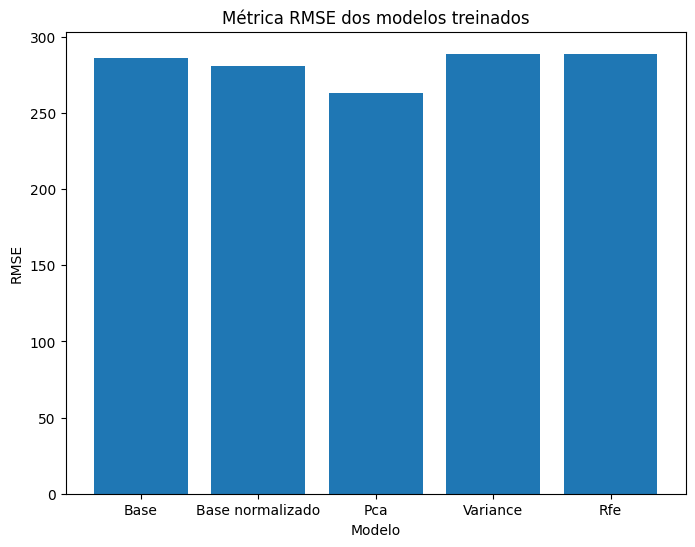

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(["Base", "Base normalizado", "Pca", "Variance", "Rfe"], desempenhos, label="Desempenhos")
ax.set_xlabel("Modelo")
ax.set_ylabel("RMSE")
ax.set_title("Métrica RMSE dos modelos treinados")
ax.legend;

## Análises dos resultados 

Assim podemos observar que o modelo de melhor desempenho foi de fato o com os dados tratados por PCA. Ademais, é possível observar que as outras estratégias não apresentaram desempenho muito diferente dos modelos base, indicando que, para o conjunto de dados trabalhado, elas por sí só não foram suficientes para melhorar o desempenho do modelo. 

## Conclusão 

Dessa forma, este trabalho permitiu o estudo de novas estratégias de tratamento de dados, através de redução de dimensionalidade e seleção de atributos, explorando os algoritmos *Principal component analysis*, *Variance Threshold* e *Recursive feature elimination*. Além disso, o trabalho possibilitou aprender como utilizar o módulo optuna para otimizar parêmetros e testar diferentes estratégias de tratamento de dados. 

## Referências 

1. Material de Aula da Disciplina
2. [Documentação SKleaarn - PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
3. [Documentação SKleaarn - VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.)
4. [Documentação SKleaarn - RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)
5. [Wikipedia EN - Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)
6. [IBM - What is principal component analysis (PCA)?](https://www.ibm.com/think/topics/principal-component-analysis)
7. [StatQuest - PCA](https://www.youtube.com/watch?v=FgakZw6K1QQ)